## Face Detection

In [1]:
import mediapipe as mp
import cv2 
from PIL import Image
import numpy as np


2023-07-10 12:11:25.280818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 12:11:25.313844: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 12:11:25.315007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 12:11:26.154216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading the model 

In [2]:
face_detection = mp.solutions.face_detection
detectmodel = face_detection.FaceDetection(min_detection_confidence=0.7)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Reading the image

In [62]:
## please make sure the path of the image is correct and available

img1 = cv2.imread("img1.jpg")
img2 = cv2.imread("img2.jpg")
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)


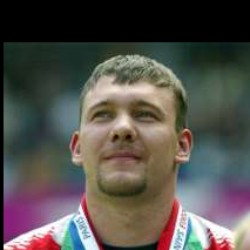

In [63]:
x = Image.fromarray(img1)
x

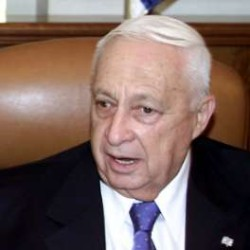

In [64]:
y = Image.fromarray(img2)
y

### Detection of Faces

In [65]:
## target size for face net is (none,160,160,3)

In [66]:
detect1 = detectmodel.process(img1)
detect2 = detectmodel.process(img2)

In [67]:
bbox1 = detect1.detections[0].location_data.relative_bounding_box
bbox2 = detect2.detections[0].location_data.relative_bounding_box

In [68]:
print(f"img1: {img1.shape}")
print(f"img2: {img2.shape}")

img1: (250, 250, 3)
img2: (250, 250, 3)


In [69]:
## cropping the image at the bounding box
## img1 
lx1 = int(bbox1.xmin*250)
ly1 = int(bbox1.ymin*250)
rx1 = int(bbox1.width*250+lx1)
ry1 = int(bbox1.height*250+ly1)
crop1 = img1[ly1:ry1,lx1:rx1]

In [70]:
lx2 = int(bbox2.xmin*250)
ly2 = int(bbox2.ymin*250)
rx2 = int(bbox2.width*250+lx2)
ry2 = int(bbox2.height*250+ly2)
crop2 = img2[ly2:ry2,lx2:rx2]

In [71]:
print(f"crop1 : {crop1.shape}")
print(f"crop2 : {crop2.shape}")

crop1 : (90, 90, 3)
crop2 : (119, 119, 3)


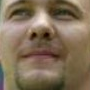

In [72]:
Image.fromarray(crop1)

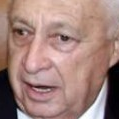

In [73]:
Image.fromarray(crop2)

## Resize the faces to (160,160,3) which is ideal for FaceNet

In [74]:
print(f"crop1 : {crop1.shape}")
print(f"crop2 : {crop2.shape}")

crop1 : (90, 90, 3)
crop2 : (119, 119, 3)


In [75]:
target_size = (160,160,3)

In [76]:
## resizing the crop1
factor1 = target_size[0]/crop1.shape[0]
factor2 = target_size[1]/crop1.shape[1]

minfact = min(factor1,factor2)

resize = (int(crop1.shape[1]*minfact),int(crop1.shape[0]*minfact))

In [77]:
rescrop1 = cv2.resize(crop1,resize)

In [78]:
rescrop1.shape

(160, 160, 3)

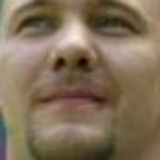

In [79]:
Image.fromarray(rescrop1)

In [80]:
## resizing for crop2 
factor1 = target_size[0]/crop2.shape[0]
factor2 = target_size[0]/crop2.shape[1]

minfact = min(factor1,factor2)
resize = resize = (int(crop2.shape[1]*minfact),int(crop2.shape[0]*minfact))

rescrop2 = cv2.resize(crop2,resize)

In [81]:
rescrop2.shape

(160, 160, 3)

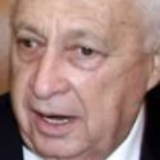

In [82]:
Image.fromarray(rescrop2)

In [25]:
firstimage = np.expand_dims(rescrop1/255,0)
secondimage = np.expand_dims(rescrop2/255,0)

### from the above steps we have taken a image and extracted the face out of the iamge and resized to the target size , now we can pass the faces to the network for finding the face embedding and then we will calculate the similarrity between the embedding to recognize both image are same or not 

## Face Recognition 

In [26]:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Activation
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.layers import Concatenate
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import GlobalAveragePooling2D
    from tensorflow.keras.layers import Input
    from tensorflow.keras.layers import Lambda
    from tensorflow.keras.layers import MaxPooling2D
    from tensorflow.keras.layers import add
    from tensorflow.keras import backend as K
    import tensorflow as tf
    import gdown

### Building the model architecture and Loading the pretrained weights

In [27]:
def scaling(x, scale):
    return x * scale


def InceptionResNetV2(dimension=512):

    inputs = Input(shape=(160, 160, 3))
    x = Conv2D(32, 3, strides=2, padding="valid", use_bias=False, name="Conv2d_1a_3x3")(inputs)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_1a_3x3_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_1a_3x3_Activation")(x)
    x = Conv2D(32, 3, strides=1, padding="valid", use_bias=False, name="Conv2d_2a_3x3")(x)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_2a_3x3_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_2a_3x3_Activation")(x)
    x = Conv2D(64, 3, strides=1, padding="same", use_bias=False, name="Conv2d_2b_3x3")(x)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_2b_3x3_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_2b_3x3_Activation")(x)
    x = MaxPooling2D(3, strides=2, name="MaxPool_3a_3x3")(x)
    x = Conv2D(80, 1, strides=1, padding="valid", use_bias=False, name="Conv2d_3b_1x1")(x)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_3b_1x1_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_3b_1x1_Activation")(x)
    x = Conv2D(192, 3, strides=1, padding="valid", use_bias=False, name="Conv2d_4a_3x3")(x)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_4a_3x3_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_4a_3x3_Activation")(x)
    x = Conv2D(256, 3, strides=2, padding="valid", use_bias=False, name="Conv2d_4b_3x3")(x)
    x = BatchNormalization(
        axis=3, momentum=0.995, epsilon=0.001, scale=False, name="Conv2d_4b_3x3_BatchNorm"
    )(x)
    x = Activation("relu", name="Conv2d_4b_3x3_Activation")(x)

    # 5x Block35 (Inception-ResNet-A block):
    branch_0 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block35_1_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_1_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_1_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_1_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_1_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_1_Branch_2_Conv2d_0c_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_1_Branch_2_Conv2d_0c_3x3_Activation")(branch_2)
    branches = [branch_0, branch_1, branch_2]
    mixed = Concatenate(axis=3, name="Block35_1_Concatenate")(branches)
    up = Conv2D(256, 1, strides=1, padding="same", use_bias=True, name="Block35_1_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.17})(up)
    x = add([x, up])
    x = Activation("relu", name="Block35_1_Activation")(x)

    branch_0 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block35_2_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_2_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_2_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_2_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_2_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_2_Branch_2_Conv2d_0c_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_2_Branch_2_Conv2d_0c_3x3_Activation")(branch_2)
    branches = [branch_0, branch_1, branch_2]
    mixed = Concatenate(axis=3, name="Block35_2_Concatenate")(branches)
    up = Conv2D(256, 1, strides=1, padding="same", use_bias=True, name="Block35_2_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.17})(up)
    x = add([x, up])
    x = Activation("relu", name="Block35_2_Activation")(x)

    branch_0 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block35_3_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_3_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_3_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_3_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_3_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_3_Branch_2_Conv2d_0c_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_3_Branch_2_Conv2d_0c_3x3_Activation")(branch_2)
    branches = [branch_0, branch_1, branch_2]
    mixed = Concatenate(axis=3, name="Block35_3_Concatenate")(branches)
    up = Conv2D(256, 1, strides=1, padding="same", use_bias=True, name="Block35_3_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.17})(up)
    x = add([x, up])
    x = Activation("relu", name="Block35_3_Activation")(x)

    branch_0 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block35_4_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_4_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_4_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_4_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_4_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_4_Branch_2_Conv2d_0c_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_4_Branch_2_Conv2d_0c_3x3_Activation")(branch_2)
    branches = [branch_0, branch_1, branch_2]
    mixed = Concatenate(axis=3, name="Block35_4_Concatenate")(branches)
    up = Conv2D(256, 1, strides=1, padding="same", use_bias=True, name="Block35_4_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.17})(up)
    x = add([x, up])
    x = Activation("relu", name="Block35_4_Activation")(x)

    branch_0 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block35_5_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_5_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block35_5_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        32, 1, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_5_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_5_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        32, 3, strides=1, padding="same", use_bias=False, name="Block35_5_Branch_2_Conv2d_0c_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Block35_5_Branch_2_Conv2d_0c_3x3_Activation")(branch_2)
    branches = [branch_0, branch_1, branch_2]
    mixed = Concatenate(axis=3, name="Block35_5_Concatenate")(branches)
    up = Conv2D(256, 1, strides=1, padding="same", use_bias=True, name="Block35_5_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.17})(up)
    x = add([x, up])
    x = Activation("relu", name="Block35_5_Activation")(x)

    # Mixed 6a (Reduction-A block):
    branch_0 = Conv2D(
        384, 3, strides=2, padding="valid", use_bias=False, name="Mixed_6a_Branch_0_Conv2d_1a_3x3"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Mixed_6a_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192, 3, strides=1, padding="same", use_bias=False, name="Mixed_6a_Branch_1_Conv2d_0b_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation")(branch_1)
    branch_1 = Conv2D(
        256, 3, strides=2, padding="valid", use_bias=False, name="Mixed_6a_Branch_1_Conv2d_1a_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation")(branch_1)
    branch_pool = MaxPooling2D(
        3, strides=2, padding="valid", name="Mixed_6a_Branch_2_MaxPool_1a_3x3"
    )(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=3, name="Mixed_6a")(branches)

    # 10x Block17 (Inception-ResNet-B block):
    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_1_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_1_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_1_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_1_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_1_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_1_Branch_1_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_1_Branch_1_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_1_Branch_1_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_1_Branch_1_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_1_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_1_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_1_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_2_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_2_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_2_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_2_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_2_Branch_2_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_2_Branch_2_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_2_Branch_2_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_2_Branch_2_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_2_Branch_2_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_2_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_2_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_2_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_3_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_3_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_3_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_3_Branch_3_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_3_Branch_3_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_3_Branch_3_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_3_Branch_3_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_3_Branch_3_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_3_Branch_3_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_3_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_3_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_3_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_4_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_4_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_4_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_4_Branch_4_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_4_Branch_4_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_4_Branch_4_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_4_Branch_4_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_4_Branch_4_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_4_Branch_4_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_4_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_4_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_4_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_5_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_5_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_5_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_5_Branch_5_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_5_Branch_5_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_5_Branch_5_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_5_Branch_5_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_5_Branch_5_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_5_Branch_5_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_5_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_5_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_5_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_6_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_6_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_6_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_6_Branch_6_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_6_Branch_6_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_6_Branch_6_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_6_Branch_6_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_6_Branch_6_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_6_Branch_6_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_6_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_6_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_6_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_7_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_7_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_7_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_7_Branch_7_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_7_Branch_7_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_7_Branch_7_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_7_Branch_7_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_7_Branch_7_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_7_Branch_7_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_7_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_7_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_7_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_8_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_8_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_8_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_8_Branch_8_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_8_Branch_8_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_8_Branch_8_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_8_Branch_8_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_8_Branch_8_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_8_Branch_8_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_8_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_8_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_8_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_9_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_9_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_9_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_9_Branch_9_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_9_Branch_9_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_9_Branch_9_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_9_Branch_9_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_9_Branch_9_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_9_Branch_9_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_9_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_9_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_9_Activation")(x)

    branch_0 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_10_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_10_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block17_10_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        128, 1, strides=1, padding="same", use_bias=False, name="Block17_10_Branch_10_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_10_Branch_10_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [1, 7],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_10_Branch_10_Conv2d_0b_1x7",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_10_Branch_10_Conv2d_0b_1x7_Activation")(branch_1)
    branch_1 = Conv2D(
        128,
        [7, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block17_10_Branch_10_Conv2d_0c_7x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block17_10_Branch_10_Conv2d_0c_7x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block17_10_Concatenate")(branches)
    up = Conv2D(896, 1, strides=1, padding="same", use_bias=True, name="Block17_10_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.1})(up)
    x = add([x, up])
    x = Activation("relu", name="Block17_10_Activation")(x)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = Conv2D(
        256, 1, strides=1, padding="same", use_bias=False, name="Mixed_7a_Branch_0_Conv2d_0a_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation")(branch_0)
    branch_0 = Conv2D(
        384, 3, strides=2, padding="valid", use_bias=False, name="Mixed_7a_Branch_0_Conv2d_1a_3x3"
    )(branch_0)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation")(branch_0)
    branch_1 = Conv2D(
        256, 1, strides=1, padding="same", use_bias=False, name="Mixed_7a_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        256, 3, strides=2, padding="valid", use_bias=False, name="Mixed_7a_Branch_1_Conv2d_1a_3x3"
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation")(branch_1)
    branch_2 = Conv2D(
        256, 1, strides=1, padding="same", use_bias=False, name="Mixed_7a_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation")(branch_2)
    branch_2 = Conv2D(
        256, 3, strides=1, padding="same", use_bias=False, name="Mixed_7a_Branch_2_Conv2d_0b_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation")(branch_2)
    branch_2 = Conv2D(
        256, 3, strides=2, padding="valid", use_bias=False, name="Mixed_7a_Branch_2_Conv2d_1a_3x3"
    )(branch_2)
    branch_2 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm",
    )(branch_2)
    branch_2 = Activation("relu", name="Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation")(branch_2)
    branch_pool = MaxPooling2D(
        3, strides=2, padding="valid", name="Mixed_7a_Branch_3_MaxPool_1a_3x3"
    )(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=3, name="Mixed_7a")(branches)

    # 5x Block8 (Inception-ResNet-C block):

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_1_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_1_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_1_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_1_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_1_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_1_Branch_1_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_1_Branch_1_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_1_Branch_1_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_1_Branch_1_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_1_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_1_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.2})(up)
    x = add([x, up])
    x = Activation("relu", name="Block8_1_Activation")(x)

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_2_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_2_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_2_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_2_Branch_2_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_2_Branch_2_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_2_Branch_2_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_2_Branch_2_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_2_Branch_2_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_2_Branch_2_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_2_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_2_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.2})(up)
    x = add([x, up])
    x = Activation("relu", name="Block8_2_Activation")(x)

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_3_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_3_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_3_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_3_Branch_3_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_3_Branch_3_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_3_Branch_3_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_3_Branch_3_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_3_Branch_3_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_3_Branch_3_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_3_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_3_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.2})(up)
    x = add([x, up])
    x = Activation("relu", name="Block8_3_Activation")(x)

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_4_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_4_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_4_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_4_Branch_4_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_4_Branch_4_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_4_Branch_4_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_4_Branch_4_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_4_Branch_4_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_4_Branch_4_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_4_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_4_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.2})(up)
    x = add([x, up])
    x = Activation("relu", name="Block8_4_Activation")(x)

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_5_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_5_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_5_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_5_Branch_5_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_5_Branch_5_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_5_Branch_5_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_5_Branch_5_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_5_Branch_5_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_5_Branch_5_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_5_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_5_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 0.2})(up)
    x = add([x, up])
    x = Activation("relu", name="Block8_5_Activation")(x)

    branch_0 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_6_Branch_0_Conv2d_1x1"
    )(x)
    branch_0 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_6_Branch_0_Conv2d_1x1_BatchNorm",
    )(branch_0)
    branch_0 = Activation("relu", name="Block8_6_Branch_0_Conv2d_1x1_Activation")(branch_0)
    branch_1 = Conv2D(
        192, 1, strides=1, padding="same", use_bias=False, name="Block8_6_Branch_1_Conv2d_0a_1x1"
    )(x)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_6_Branch_1_Conv2d_0a_1x1_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [1, 3],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_6_Branch_1_Conv2d_0b_1x3",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_6_Branch_1_Conv2d_0b_1x3_Activation")(branch_1)
    branch_1 = Conv2D(
        192,
        [3, 1],
        strides=1,
        padding="same",
        use_bias=False,
        name="Block8_6_Branch_1_Conv2d_0c_3x1",
    )(branch_1)
    branch_1 = BatchNormalization(
        axis=3,
        momentum=0.995,
        epsilon=0.001,
        scale=False,
        name="Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm",
    )(branch_1)
    branch_1 = Activation("relu", name="Block8_6_Branch_1_Conv2d_0c_3x1_Activation")(branch_1)
    branches = [branch_0, branch_1]
    mixed = Concatenate(axis=3, name="Block8_6_Concatenate")(branches)
    up = Conv2D(1792, 1, strides=1, padding="same", use_bias=True, name="Block8_6_Conv2d_1x1")(
        mixed
    )
    up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={"scale": 1})(up)
    x = add([x, up])

    # Classification block
    x = GlobalAveragePooling2D(name="AvgPool")(x)
    x = Dropout(1.0 - 0.8, name="Dropout")(x)
    # Bottleneck
    x = Dense(dimension, use_bias=False, name="Bottleneck")(x)
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name="Bottleneck_BatchNorm")(
        x
    )

    # Create model
    model = Model(inputs, x, name="inception_resnet_v1")

    return model

In [28]:
model = InceptionResNetV2()

In [ ]:
tf.keras.utils.plot_model(model)

In [30]:
## loading weights into the model 
url="https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5"
gdown.download(url,"./weights/weight.h5")

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /home/mat/projects/facerecognition/facenet/weights/weight.h5
100%|██████████████████████████████████████| 95.0M/95.0M [00:06<00:00, 14.2MB/s]


'./weights/weight.h5'

In [29]:
model.load_weights("weights/weight.h5")

In [30]:
### model will return a 512 single dimensional vector

firstembed = model.predict(firstimage)[0]
secondembed = model.predict(secondimage)[0]

1/1 [==============================] - 0s 41ms/step


In [31]:
print(f"firstembed shape : {firstembed.shape}")
print(f"secondembed shape : {secondembed.shape}")

firstembed shape : (512,)
secondembed shape : (512,)


### Calculation of similarity metric - cosine distance between the two embed 

### if cosine distance is lesser, similarity is more  and viceversa

In [32]:
def cosinedistance(embed1,embed2):
    a = np.matmul(np.transpose(embed1),embed2)
    b = np.sum(np.multiply(embed1,embed1))
    c = np.sum(np.multiply(embed2,embed2))
    cossim = a/(np.sqrt(b)*np.sqrt(c))
    distance = 1 - cossim
    return distance

In [33]:
distance = cosinedistance(firstembed,secondembed)

### Above model predicted succesfully both are differant person

In [34]:
if distance <= 0.4 : 
    print("both are same person")
else:
    print("both are diffeant person")

both are diffeant person


### Real time Recognition

In [35]:
def crop(bbox,image):
    lx = int(bbox.xmin*image.shape[1])
    ly = int(bbox.ymin*image.shape[0])
    rx = int(bbox.width*image.shape[1]+lx)
    ry = int(bbox.height*image.shape[0]+ly)
    crop = image[ly:ry,lx:rx]
    return crop

In [36]:
def resize(img,target_size):
    factor1 = target_size[0]/img.shape[0]
    factor2 = target_size[1]/img.shape[1]
    minfact = min(factor1,factor2)
    resize = (int(img.shape[1]*minfact),int(img.shape[0]*minfact))
    res = cv2.resize(img,resize)
    return res

In [54]:
## before running this ,please set the anchor to  path of the image available
def facerecognition(frame,anchor="marnus.jpeg"):
    
    ## we are checking the similarity of frame against the anchor
    ## anchor is already predefined
    ## as cv2 will read the image in BGR format , we need to convert it to RGB
    
    ## if the first image is not numpy , we need to read 
    if type(frame).__module__ != np.__name__:
        frame = cv2.imread(frame)
    
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    anchor = cv2.imread(anchor)
    anchor = cv2.cvtColor(anchor,cv2.COLOR_BGR2RGB)

        
    detect1 = detectmodel.process(frame)
    detect2 = detectmodel.process(anchor)
    
    bbox1 = detect1.detections[0].location_data.relative_bounding_box
    bbox2 = detect2.detections[0].location_data.relative_bounding_box

    
    ## cropping the image at the bounding box 
    crop1 = crop(bbox1,frame)
    crop2 = crop(bbox2,anchor)

    ## resizing crop1
    rescrop1 = resize(crop1,(160,160,3))
    rescrop2 = resize(crop2,(160,160,3))
    
    firstimage = np.expand_dims(rescrop1/255,0)
    secondimage = np.expand_dims(rescrop2/255,0)
    
    ## embedding of both image
    firstembed = loadedmodel.predict(firstimage)[0]
    secondembed = loadedmodel.predict(secondimage)[0]
    
    ## cosine distance 
    distance = cosinedistance(firstembed,secondembed)
    print(distance)
    
    if(distance<=0.4):
        print("Same person")
    else:
        print("differant person")
        

## Video real stream verfication

In [55]:
capture = cv2.VideoCapture(0)

print("Press v to verify")
print("-----------------")
print("Press q to close the cam")


while capture.isOpened():
    _,frame = capture.read()
    
    cv2.imshow("face recognition",frame)
    
    if(cv2.waitKey(1) & 0XFF == ord('v')):
        facerecognition(frame)
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break
       
       
capture.release()
cv2.destroyAllWindows()

Press v to verify
-----------------
Press q to close the cam
1/1 [==============================] - 0s 35ms/step
1.0731093734502792
differant person
1/1 [==============================] - 0s 35ms/step
1.0915707796812057
differant person
1/1 [==============================] - 0s 35ms/step
0.8321578800678253
differant person
1/1 [==============================] - 0s 36ms/step
0.6818984150886536
differant person
1/1 [==============================] - 0s 34ms/step
0.3029804229736328
Same person
1/1 [==============================] - 0s 35ms/step
0.29787546396255493
Same person



### Almost higher accuray of recognition , you can tweak the threhold for cosine distance and other thing for futher optimization


### saving the model 

In [44]:
model.save("saved_model")

2023-07-10 12:20:55.545541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1792]
	 [[{{node inputs}}]]
2023-07-10 12:21:03.168285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1792]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [53]:
loadedmodel = tf.keras.models.load_model("saved_model")
## here imchecking after loading the saved model , wheter it is working fine or not , so be make sure in the above face recognition function change model to loadmodel ## 
## check the results

### saving the model in tensorflowjs format 

In [59]:
import tensorflowjs 

In [60]:
!tensorflowjs_converter --input_format=tf_saved_model "./saved_model" "./tfjsversion/" 

2023-07-10 12:35:24.881023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
